In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**IMPORT**

In [28]:
FILE = ''
df = pd.read_csv(FILE)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,Domain,Botnet_Family,Target
0,makotv-158813.firebaseapp.com,alexa,0
1,peugeotsouthafrica.co.za,alexa,0
2,allensmusiccentre.co.uk,alexa,0
3,therustygardenbarrow.co.za,alexa,0
4,bfa9a08b2ee30821a75dcd33dcbbdf12.top,tinynuke,1


<Axes: xlabel='count', ylabel='Botnet_Family'>

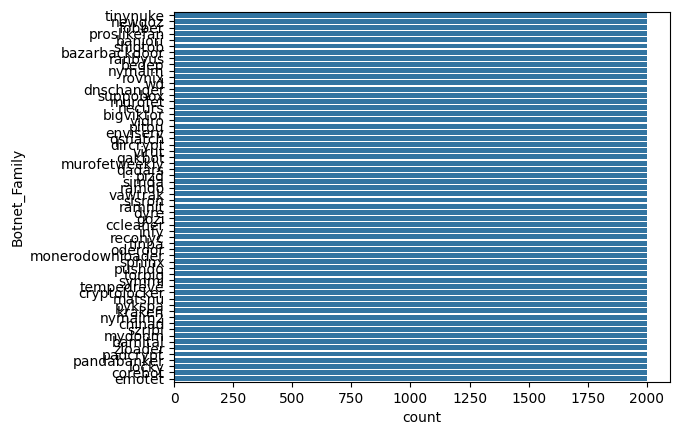

In [ ]:
import seaborn as sns
sns.countplot(df[df['Botnet_Family']!='alexa']['Botnet_Family'])

**BINARY CLASSIFIFCATION USING ML**

---



In [29]:
df = df[['Domain', 'Target']]
df.head()

,Domain,Target
0,makotv-158813.firebaseapp.com,0
1,peugeotsouthafrica.co.za,0
2,allensmusiccentre.co.uk,0
3,therustygardenbarrow.co.za,0
4,bfa9a08b2ee30821a75dcd33dcbbdf12.top,1


In [30]:
df['Target'].value_counts()

,count
Target,
0,120000
1,120000


**FEATURE ENGINEERING**

**1) CUSTOM FEATURES EXTRACTION**

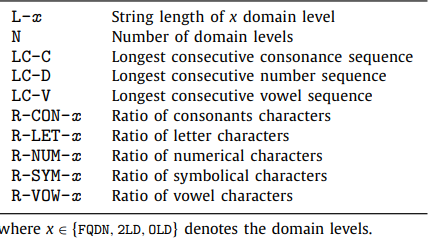

In [31]:
import re

def count_features(domain):
    # Length of domain_level
    L = len(domain)

    # Ratio of consonant characters
    consonant_count = sum(1 for char in domain if char in 'bcdfghjklmnpqrstvwxyz')
    Rc = consonant_count / len(domain) if len(domain) > 0 else 0

    # Ratio of letter characters
    letter_count = sum(1 for char in domain if char.isalpha())
    Rl = letter_count / len(domain) if len(domain) > 0 else 0

    # Ratio of numerical characters
    number_count = sum(1 for char in domain if char.isdigit())
    Rn = number_count / len(domain) if len(domain) > 0 else 0

    # Ratio of vowel characters
    vowel_count = sum(1 for char in domain if char in 'aeiou')
    Rv = vowel_count / len(domain) if len(domain) > 0 else 0

    # Ratio of symbolic characters
    symbolic_count = sum(1 for char in domain if not char.isalnum())
    Rs = symbolic_count / len(domain) if len(domain) > 0 else 0

    return L, Rc, Rv, Rn, Rl, Rs

# Calculate the domain-related features
def calculate_features(df):
    features = []

    for domain in df['Domain']:
      parts = domain.split('.')
      subdomain = '.'.join(parts[:-2]) if len(parts) >= 3 else '' # Subdomains
      sld = parts[-2] # Second level domain
      tld = parts[-1] # Top level domain

      # Number of domain levels
      N = 3 if subdomain else 2

      # Longest consecutive consonance sequence
      consonants = re.findall(r'[^aeiou\d\s\W]+', domain)
      LCc = max(len(consonant) for consonant in consonants) if consonants else 0

      # Longest consecutive number sequence
      numbers = re.findall(r'\d+', domain)
      LCn = max(len(number) for number in numbers) if numbers else 0

      # Longest consecutive vowel sequence
      vowels = re.findall(r'[aeiou]+', domain)
      LCv = max(len(vowel) for vowel in vowels) if vowels else 0

      # Features from each domain level
      L_tld, Rc_tld, Rv_tld, Rn_tld, Rl_tld, Rs_tld = count_features(tld)
      L_sld, Rc_sld, Rv_sld, Rn_sld, Rl_sld, Rs_sld = count_features(sld)
      L_sub, Rc_sub, Rv_sub, Rn_sub, Rl_sub, Rs_sub = count_features(subdomain) if subdomain else (0, 0, 0, 0, 0, 0)

      features.append([N, LCc, LCv, LCn, L_tld, Rc_tld, Rv_tld, Rn_tld, Rl_tld,Rs_tld, L_sld, Rc_sld, Rv_sld, Rn_sld, Rl_sld,Rs_sld, L_sub, Rc_sub, Rv_sub, Rn_sub, Rl_sub, Rs_sub])

    # Create a DataFrame with the features
    feature_columns = ['N', 'LCc', 'LCv', 'LCn',
                       'L_tld', 'Rc_tld', 'Rv_tld', 'Rn_tld', 'Rl_tld','Rs_tld',
                       'L_sld', 'Rc_sld', 'Rv_sld', 'Rn_sld', 'Rl_sld','Rs_sld',
                       'L_sub', 'Rc_sub', 'Rv_sub', 'Rn_sub', 'Rl_sub', 'Rs_sub']

    feature_df = pd.DataFrame(features, columns=feature_columns)

    # Concatenate with original dataframe
    return pd.concat([df, feature_df], axis=1)

In [32]:
df_custom_features=calculate_features(df)
df_custom_features.head()

,Domain,Target,N,LCc,LCv,LCn,L_tld,Rc_tld,Rv_tld,Rn_tld,...,Rv_sld,Rn_sld,Rl_sld,Rs_sld,L_sub,Rc_sub,Rv_sub,Rn_sub,Rl_sub,Rs_sub
0,makotv-158813.firebaseapp.com,0,3,2,2,6,3,0.666667,0.333333,0.0,...,0.454545,0.00000,1.00000,0.0,13,0.307692,0.153846,0.461538,0.461538,0.076923
1,peugeotsouthafrica.co.za,0,3,2,2,0,2,0.500000,0.500000,0.0,...,0.500000,0.00000,1.00000,0.0,18,0.500000,0.500000,0.000000,1.000000,0.000000
2,allensmusiccentre.co.uk,0,3,3,1,0,2,0.500000,0.500000,0.0,...,0.500000,0.00000,1.00000,0.0,17,0.647059,0.352941,0.000000,1.000000,0.000000
3,therustygardenbarrow.co.za,0,3,4,1,0,2,0.500000,0.500000,0.0,...,0.500000,0.00000,1.00000,0.0,20,0.700000,0.300000,0.000000,1.000000,0.000000
4,bfa9a08b2ee30821a75dcd33dcbbdf12.top,1,2,6,2,5,3,0.666667,0.333333,0.0,...,0.156250,0.46875,0.53125,0.0,0,0.000000,0.000000,0.000000,0.000000,0.000000


**2) N-GRAM FEATURE EXTRACTION**

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import hstack

# Extract bigrams and trigrams using TF-IDF
unigrams = TfidfVectorizer(analyzer='char', ngram_range=(1, 1))
bigrams = TfidfVectorizer(analyzer='char', ngram_range=(2, 2))
trigrams = TfidfVectorizer(analyzer='char', ngram_range=(3, 3))

unigrams_matrix = unigrams.fit_transform(df['Domain'])
bigrams_matrix = bigrams.fit_transform(df['Domain'])
trigrams_matrix = trigrams.fit_transform(df['Domain'])

In [34]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

def ngrams_features_per_sample(matrix, prefix):
    # Convert sparse matrix to dense
    ngram_frequencies = matrix.toarray()

    # Initialize a list to store feature dictionaries
    features_list = []

    # Loop through each sample
    for sample_frequencies in ngram_frequencies:
        features = {}

        # Count distinct n-grams (non-zero frequencies)
        if np.count_nonzero(sample_frequencies) > 0:  # Avoid NaN errors if no n-grams are present

            features[f'{prefix}-MEAN'] = np.mean(sample_frequencies)
            features[f'{prefix}-VAR'] = np.var(sample_frequencies)
            features[f'{prefix}-PVAR'] = np.var(sample_frequencies, ddof=0)  # Population variance
            features[f'{prefix}-STD'] = np.std(sample_frequencies)
            features[f'{prefix}-PSTD'] = np.std(sample_frequencies, ddof=0)  # Population std deviation
            features[f'{prefix}-SKE'] = skew(sample_frequencies)
            features[f'{prefix}-KUR'] = kurtosis(sample_frequencies)
        else:
            features[f'{prefix}-MEAN'] = 0
            features[f'{prefix}-VAR'] = 0
            features[f'{prefix}-PVAR'] = 0
            features[f'{prefix}-STD'] = 0
            features[f'{prefix}-PSTD'] = 0
            features[f'{prefix}-SKE'] = 0  # Skewness is 0 for no data
            features[f'{prefix}-KUR'] = 0  # Kurtosis is 0 for no data

        # Append features for this sample to the list
        features_list.append(features)

    # Convert the list of feature dictionaries into a DataFrame
    return pd.DataFrame(features_list)

In [35]:
# Extract features
unigrams_features_df = ngrams_features_per_sample(unigrams_matrix, prefix='UNI')
bigrams_features_df = ngrams_features_per_sample(bigrams_matrix, prefix='BI')
trigrams_features_df = ngrams_features_per_sample(trigrams_matrix, prefix='TRI')

# Concatenate bigrams and trigrams features
df_ngrams_features = pd.concat([unigrams_features_df, bigrams_features_df, trigrams_features_df], axis=1)
df_ngrams_features.head()

,UNI-MEAN,UNI-VAR,UNI-PVAR,UNI-STD,UNI-PSTD,UNI-SKE,UNI-KUR,BI-MEAN,BI-VAR,BI-PVAR,...,BI-PSTD,BI-SKE,BI-KUR,TRI-MEAN,TRI-VAR,TRI-PVAR,TRI-STD,TRI-PSTD,TRI-SKE,TRI-KUR
0,0.094733,0.014835,0.014835,0.121800,0.121800,1.295973,1.206725,0.003365,0.000658,0.000658,...,0.025661,8.160170,70.042122,0.000099,0.00002,0.00002,0.004446,0.004446,47.494237,2356.758448
1,0.087723,0.016114,0.016114,0.126942,0.126942,1.059507,-0.264562,0.003117,0.000660,0.000660,...,0.025692,8.523884,74.270804,0.000090,0.00002,0.00002,0.004447,0.004447,50.640656,2615.815900
2,0.081867,0.017107,0.017107,0.130795,0.130795,1.351040,0.383998,0.002958,0.000661,0.000661,...,0.025711,9.152375,87.477887,0.000088,0.00002,0.00002,0.004447,0.004447,52.073996,2783.141497
3,0.089216,0.015850,0.015850,0.125897,0.125897,1.495102,2.292505,0.003154,0.000660,0.000660,...,0.025687,8.563028,75.755601,0.000095,0.00002,0.00002,0.004447,0.004447,47.968061,2338.607815
4,0.087034,0.016235,0.016235,0.127415,0.127415,1.338146,0.569666,0.003730,0.000656,0.000656,...,0.025610,7.385776,59.848191,0.000115,0.00002,0.00002,0.004446,0.004446,38.992751,1526.046266


**CONCAT CUSTOM + N-GRAM FEATURES**

In [36]:
df_final = pd.concat([df_custom_features, df_ngrams_features], axis=1)

In [37]:
df_final.head()

,Domain,Target,N,LCc,LCv,LCn,L_tld,Rc_tld,Rv_tld,Rn_tld,...,BI-PSTD,BI-SKE,BI-KUR,TRI-MEAN,TRI-VAR,TRI-PVAR,TRI-STD,TRI-PSTD,TRI-SKE,TRI-KUR
0,makotv-158813.firebaseapp.com,0,3,2,2,6,3,0.666667,0.333333,0.0,...,0.025661,8.160170,70.042122,0.000099,0.00002,0.00002,0.004446,0.004446,47.494237,2356.758448
1,peugeotsouthafrica.co.za,0,3,2,2,0,2,0.500000,0.500000,0.0,...,0.025692,8.523884,74.270804,0.000090,0.00002,0.00002,0.004447,0.004447,50.640656,2615.815900
2,allensmusiccentre.co.uk,0,3,3,1,0,2,0.500000,0.500000,0.0,...,0.025711,9.152375,87.477887,0.000088,0.00002,0.00002,0.004447,0.004447,52.073996,2783.141497
3,therustygardenbarrow.co.za,0,3,4,1,0,2,0.500000,0.500000,0.0,...,0.025687,8.563028,75.755601,0.000095,0.00002,0.00002,0.004447,0.004447,47.968061,2338.607815
4,bfa9a08b2ee30821a75dcd33dcbbdf12.top,1,2,6,2,5,3,0.666667,0.333333,0.0,...,0.025610,7.385776,59.848191,0.000115,0.00002,0.00002,0.004446,0.004446,38.992751,1526.046266


In [38]:
X = df_final.drop(['Domain','Target'], axis=1)
y = df_final['Target']

**MODEL TRAINING**

In [39]:
pip install xgboost

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, label_binarize

In [41]:
print(xgb.__version__)

2.1.2


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**5-fold cross validation and ROC plotting**

In [ ]:
models = {
    'XGBoost': XGBClassifier(eval_metric='mlogloss', random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'k-Nearest Neighbours': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(random_state=42)
}

k = 5
results = {'Accuracy': {}, 'F1 Score': {}}
roc_curves = {}

# Cross-validation and ROC curve plotting
for model_name, model in models.items():
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    accuracy_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    #f1_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted')

    results['Accuracy'][model_name] = accuracy_scores.mean()
    #results['F1 Score'][model_name] = f1_scores.mean()

    print(f"{model_name} Accuracy: {accuracy_scores.mean():.4f}")
    #print(f"F1 Score: {f1_scores.mean():.4f}")

    #calc roc values for each model
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    roc_curves[model_name] = (fpr, tpr, roc_auc)

In [ ]:
# Plot ROC Curves
plt.figure(figsize=(10, 8))
for model_name, (fpr, tpr, roc_auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

**Evaluation**

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import accuracy_score

Test Accuracy: 89.42%


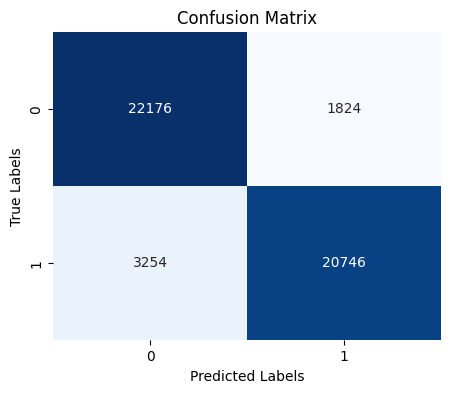

In [17]:
final_model = XGBClassifier(eval_metric='mlogloss', random_state=42)

final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

**HYPERPARAMETER TUNING**

In [13]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [300, 500, 1000],
    'max_depth': [5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'reg_lambda': [0.1, 1, 10]
}

xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy',
                           cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 1000, 'reg_lambda': 10}
Best accuracy:  0.9028177083333334


Test Accuracy: 90.65%


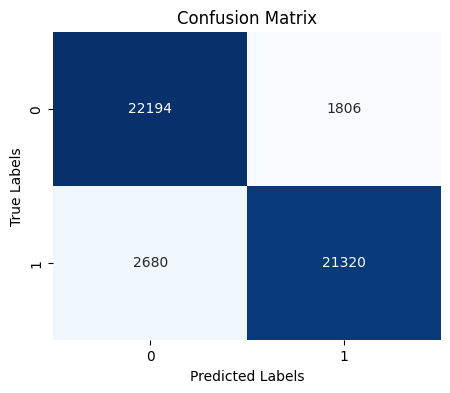

In [45]:
xgb_model = grid_search.best_estimator_

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import joblib
joblib.dump(unigrams, 'unigram_vectorizer.pkl')
joblib.dump(bigrams, 'bigram_vectorizer.pkl')
joblib.dump(trigrams, 'trigram_vectorizer.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(xgb_model, 'binary_classification_model.pkl')

prediction trials

In [120]:
input_domain = "scanned-fancy.la"

In [121]:
df = pd.DataFrame({'Domain': [input_domain]})

In [122]:
df_custom_features = calculate_features(df)
df_custom_features

,Domain,N,LCc,LCv,LCn,L_tld,Rc_tld,Rv_tld,Rn_tld,Rl_tld,...,Rv_sld,Rn_sld,Rl_sld,Rs_sld,L_sub,Rc_sub,Rv_sub,Rn_sub,Rl_sub,Rs_sub
0,scanned-fancy.la,2,3,1,0,2,0.5,0.5,0.0,1.0,...,0.230769,0.0,0.923077,0.076923,0,0,0,0,0,0


In [123]:
unigrams_matrix = unigrams.transform(df['Domain'])
bigrams_matrix = bigrams.transform(df['Domain'])
trigrams_matrix = trigrams.transform(df['Domain'])

unigrams_features_df = ngrams_features_per_sample(unigrams_matrix, prefix='UNI')
bigrams_features_df = ngrams_features_per_sample(bigrams_matrix, prefix='BI')
trigrams_features_df = ngrams_features_per_sample(trigrams_matrix, prefix='TRI')

# Concatenate bigrams and trigrams features
df_ngrams_features = pd.concat([unigrams_features_df, bigrams_features_df, trigrams_features_df], axis=1)
df_ngrams_features

,UNI-MEAN,UNI-VAR,UNI-PVAR,UNI-STD,UNI-PSTD,UNI-SKE,UNI-KUR,BI-MEAN,BI-VAR,BI-PVAR,...,BI-PSTD,BI-SKE,BI-KUR,TRI-MEAN,TRI-VAR,TRI-PVAR,TRI-STD,TRI-PSTD,TRI-SKE,TRI-KUR
0,0.071765,0.018659,0.018659,0.136599,0.136599,1.875922,2.537754,0.002441,0.000664,0.000664,...,0.025765,10.955782,122.859209,0.000073,0.00002,0.00002,0.004447,0.004447,61.820227,3891.145664


In [124]:
df_final = pd.concat([df_custom_features, df_ngrams_features], axis=1)
df_final

,Domain,N,LCc,LCv,LCn,L_tld,Rc_tld,Rv_tld,Rn_tld,Rl_tld,...,BI-PSTD,BI-SKE,BI-KUR,TRI-MEAN,TRI-VAR,TRI-PVAR,TRI-STD,TRI-PSTD,TRI-SKE,TRI-KUR
0,scanned-fancy.la,2,3,1,0,2,0.5,0.5,0.0,1.0,...,0.025765,10.955782,122.859209,0.000073,0.00002,0.00002,0.004447,0.004447,61.820227,3891.145664


In [125]:
X = scaler.transform(df_final.drop('Domain', axis=1))

In [126]:
xgb_model.predict(X)

array([0])

In [127]:
xgb_model.predict_proba(X)

array([[0.88852495, 0.11147506]], dtype=float32)